In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from functools import partial
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import data_transformers as dt
import model_wrapper as mw
from data_transformers import create_molecular_features, process_molecular_features
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from auxiliary import plotScatterWithIdeal, get_logger
from paths import DATA_DIR, PIPELINES_DIR, MODELS_DIR

from enum import Enum
class ColumnNames(Enum):
    SMILES_COLUMN = "canonical_smiles"
    TARGET_COLUMN = "standard_value_mean"

pd.set_option("display.max_rows", 500)
l = get_logger(logger_name="logger")
USE_CASE = "gyrase"

2022-07-31 08:18:34.678486: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
df = pd.read_parquet(DATA_DIR/USE_CASE/"final_aggregates_chembl_binding_pdb.parquet")
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,standard_value_get_mean,db_id,canonical_smiles,source,activity
0,28000.0,28000.0,[28000.0],2.800000e+04,CHEMBL4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,chembl,inactive
1,4750000.0,4750000.0,[4750000.0],4.750000e+06,CHEMBL5,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,chembl,inactive
2,10600.0,37725.5,"[10600.0, 37725.5]",2.416275e+04,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,chembl,inactive
3,6000.0,12500.0,"[6000.0, 8100.0, 10000.0, 11200.0, 12500.0]",1.043333e+04,CHEMBL32,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,chembl,active
4,50000.0,50000.0,[50000.0],5.000000e+04,CHEMBL64,NNC(=O)c1ccncc1,chembl,inactive


* an additional aggregation related to duplicated entry - the explanations are in the notebook related to the data retrieval (data_retrieval_chembl3.0.ipynb), the other project (DNA_GYRAZE) 

In [3]:
def combine_lists(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        a = [item for item in x]
        ret_val = []
        for item in a: ret_val.extend(item)
        return ret_val

In [4]:
df = df.groupby("db_id").agg({"standard_value_min": min, "standard_value_max": max, "standard_value_get_all_levels": combine_lists, "db_id": min,
"canonical_smiles": min, "source": min})

In [5]:
df["standard_value_mean"] = df["standard_value_get_all_levels"].apply(lambda x: np.array(x).mean())
df["standard_value_mean"] = df["standard_value_mean"].astype(float)
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,
50117914,5.0,9400.0,"[5.0, 7990.0, 9400.0]",50117914,COc1c(N2CCNC(C)C2)c(F)cc2c1n(cc(C(O)=O)c2=O)C1CC1,bindingpdb,5798.333333
50131428,9200.0,9200.0,[9200.0],50131428,COc1c(N2CC3CCCNC3C2)c(F)cc2C(=O)C(CN(C3CC3)c12...,bindingpdb,9200.000000
50131445,52000.0,52000.0,[52000.0],50131445,COC(=O)c1cn2[C@@H](C)COc3c(N4CCN(C)CC4)c(F)cc(...,bindingpdb,52000.000000
50330327,2900.0,2900.0,[2900.0],50330327,COc1c(N2CC[C@H](C2)C(C)(C)N)c(F)cc2c1n(C1CC1)c...,bindingpdb,2900.000000
50490565,48400.0,48400.0,[48400.0],50490565,CCOC(=O)C1CN(CCN1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)...,bindingpdb,48400.000000


In [6]:
df[df["db_id"].duplicated(keep=False)]

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,


# QED regression

## Training

In [7]:
TRAINING_CONFIGURATION_FILE = "QED_training_gyrase_regression.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 08:18:43,089 - logger - INFO - Scaler constructor...
2022-07-31 08:18:43,091 - logger - INFO - CreateFPS fit...
2022-07-31 08:18:43,092 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 305.95it/s]


In [8]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

2022-07-31 08:18:55,269 - logger - INFO - Scaler fit...
2022-07-31 08:18:55,273 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,279 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,749 - logger - INFO - Scaler fit...
2022-07-31 08:18:55,752 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,757 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,193 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,197 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,201 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,428 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,431 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,435 - logger - INFO - Scaler transform...


  0%|          | 1/200 [00:01<04:40,  1.41s/it, best loss: 0.4679554793114231]

2022-07-31 08:18:56,677 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,679 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,683 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,042 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,045 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,049 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,208 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,211 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,216 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,395 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,398 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,402 - logger - INFO - Scaler transform...


  1%|          | 2/200 [00:02<03:43,  1.13s/it, best loss: 0.4679554793114231]

2022-07-31 08:18:57,605 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,608 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,611 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,110 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,114 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,118 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,344 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,347 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,352 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,560 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,563 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,567 - logger - INFO - Scaler transform...


  2%|▏         | 3/200 [00:03<03:49,  1.16s/it, best loss: 0.4595762315769787]

2022-07-31 08:18:58,817 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,819 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,824 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,402 - logger - INFO - Scaler fit...
2022-07-31 08:18:59,406 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,411 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,760 - logger - INFO - Scaler fit...
2022-07-31 08:18:59,763 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,768 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,128 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,131 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,136 - logger - INFO - Scaler transform...


  2%|▏         | 4/200 [00:05<04:28,  1.37s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:00,501 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,504 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,508 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,985 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,989 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,994 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,333 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,337 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,342 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,608 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,611 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,616 - logger - INFO - Scaler transform...


  2%|▎         | 5/200 [00:06<04:27,  1.37s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:01,875 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,878 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,883 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,376 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,380 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,385 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,668 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,672 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,677 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,983 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,986 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,991 - logger - INFO - Scaler transform...


  3%|▎         | 6/200 [00:08<04:38,  1.44s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:03,662 - logger - INFO - Scaler fit...
2022-07-31 08:19:03,665 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,670 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,890 - logger - INFO - Scaler fit...
2022-07-31 08:19:03,893 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,898 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,150 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,153 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,158 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,384 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,387 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,392 - logger - INFO - Scaler transform...


  4%|▎         | 7/200 [00:09<04:20,  1.35s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:04,610 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,613 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,617 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,164 - logger - INFO - Scaler fit...
2022-07-31 08:19:05,168 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,172 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,515 - logger - INFO - Scaler fit...
2022-07-31 08:19:05,519 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,523 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,999 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,003 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,008 - logger - INFO - Scaler transform...


  4%|▍         | 8/200 [00:11<04:42,  1.47s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:06,349 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,356 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,764 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,767 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,772 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,960 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,963 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,967 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,157 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,161 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,166 - logger - INFO - Scaler transform...


  4%|▍         | 9/200 [00:12<04:15,  1.34s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:07,389 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,392 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,396 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,868 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,872 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,876 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,305 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,308 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,313 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,467 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,471 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,475 - logger - INFO - Scaler transform...


  5%|▌         | 10/200 [00:13<04:08,  1.31s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:08,634 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,637 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,641 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,698 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,701 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,706 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,042 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,046 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,051 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,122 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,126 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,130 - logger - INFO - Scaler transform...


  6%|▌         | 11/200 [00:13<03:23,  1.08s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:09,187 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,189 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,193 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,874 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,878 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,882 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,275 - logger - INFO - Scaler fit...
2022-07-31 08:19:10,278 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,282 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,641 - logger - INFO - Scaler fit...
2022-07-31 08:19:10,644 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,649 - logger - INFO - Scaler transform...


  6%|▌         | 12/200 [00:15<04:06,  1.31s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:11,036 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,038 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,041 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,500 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,503 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,508 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,767 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,770 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,775 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,020 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,023 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,027 - logger - INFO - Scaler transform...


  6%|▋         | 13/200 [00:17<04:23,  1.41s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:12,676 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,679 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,684 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,882 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,886 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,891 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,092 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,097 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,102 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,586 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,590 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,594 - logger - INFO - Scaler transform...


  7%|▋         | 14/200 [00:18<04:07,  1.33s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:13,822 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,825 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,829 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,343 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,347 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,545 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,554 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,774 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,778 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,782 - logger - INFO - Scaler transform...


  8%|▊         | 15/200 [00:19<04:10,  1.35s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:15,221 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,224 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,228 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,383 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,386 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,390 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,563 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,567 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,571 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,932 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,935 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,940 - logger - INFO - Scaler transform...


  8%|▊         | 16/200 [00:20<03:41,  1.21s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:16,090 - logger - INFO - Scaler fit...
2022-07-31 08:19:16,093 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,097 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,966 - logger - INFO - Scaler fit...
2022-07-31 08:19:16,971 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,975 - logger - INFO - Scaler transform...
2022-07-31 08:19:17,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:17,512 - logger - INFO - Scaler transform...
2022-07-31 08:19:17,517 - logger - INFO - Scaler transform...
2022-07-31 08:19:18,490 - logger - INFO - Scaler fit...
2022-07-31 08:19:18,494 - logger - INFO - Scaler transform...
2022-07-31 08:19:18,499 - logger - INFO - Scaler transform...


  8%|▊         | 17/200 [00:23<05:19,  1.75s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:19,096 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,099 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,103 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,420 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,423 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,428 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,913 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,917 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,921 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,208 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,211 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,216 - logger - INFO - Scaler transform...


  9%|▉         | 18/200 [00:25<05:01,  1.66s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:20,546 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,552 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,883 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,887 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,891 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,058 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,061 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,066 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,226 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,229 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,233 - logger - INFO - Scaler transform...


 10%|▉         | 19/200 [00:26<04:16,  1.42s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:21,410 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,412 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,416 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,793 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,797 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,802 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,900 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,903 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,908 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,034 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,037 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,042 - logger - INFO - Scaler transform...


 10%|█         | 20/200 [00:26<03:38,  1.21s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:22,149 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,151 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,155 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,385 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,388 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,393 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,861 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,865 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,869 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,091 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,095 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,099 - logger - INFO - Scaler transform...


 10%|█         | 21/200 [00:28<03:35,  1.20s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:23,330 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,332 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,336 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,592 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,595 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,600 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,715 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,718 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,722 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,804 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,807 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,812 - logger - INFO - Scaler transform...


 11%|█         | 22/200 [00:28<03:05,  1.04s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:23,990 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,993 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,997 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,343 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,347 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,423 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,426 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,431 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,504 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,507 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,511 - logger - INFO - Scaler transform...


 12%|█▏        | 23/200 [00:29<02:53,  1.02it/s, best loss: 0.45202610878839855]

2022-07-31 08:19:24,843 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,847 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,851 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,545 - logger - INFO - Scaler fit...
2022-07-31 08:19:25,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,554 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,996 - logger - INFO - Scaler fit...
2022-07-31 08:19:25,999 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,004 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,594 - logger - INFO - Scaler fit...
2022-07-31 08:19:26,597 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,602 - logger - INFO - Scaler transform...


 12%|█▏        | 24/200 [00:31<03:58,  1.35s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:27,065 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,068 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,072 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,304 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,307 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,312 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,511 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,515 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,519 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,720 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,724 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,728 - logger - INFO - Scaler transform...


 12%|█▎        | 25/200 [00:32<03:38,  1.25s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:28,058 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,061 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,065 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,583 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,587 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,592 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,795 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,799 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,803 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,984 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,987 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,993 - logger - INFO - Scaler transform...


 13%|█▎        | 26/200 [00:34<03:39,  1.26s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:29,354 - logger - INFO - Scaler fit...
2022-07-31 08:19:29,358 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,362 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,971 - logger - INFO - Scaler fit...
2022-07-31 08:19:29,975 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,980 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,359 - logger - INFO - Scaler fit...
2022-07-31 08:19:30,363 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,368 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,746 - logger - INFO - Scaler fit...
2022-07-31 08:19:30,750 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,754 - logger - INFO - Scaler transform...


 14%|█▎        | 27/200 [00:36<04:17,  1.49s/it, best loss: 0.4354588054710442] 

2022-07-31 08:19:31,373 - logger - INFO - Scaler fit...
2022-07-31 08:19:31,375 - logger - INFO - Scaler transform...
2022-07-31 08:19:31,379 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,139 - logger - INFO - Scaler fit...
2022-07-31 08:19:32,143 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,148 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,727 - logger - INFO - Scaler fit...
2022-07-31 08:19:32,731 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,735 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,309 - logger - INFO - Scaler fit...
2022-07-31 08:19:33,313 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,317 - logger - INFO - Scaler transform...


 14%|█▍        | 28/200 [00:38<05:10,  1.80s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:33,913 - logger - INFO - Scaler fit...
2022-07-31 08:19:33,916 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,920 - logger - INFO - Scaler transform...
2022-07-31 08:19:34,614 - logger - INFO - Scaler fit...
2022-07-31 08:19:34,618 - logger - INFO - Scaler transform...
2022-07-31 08:19:34,624 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,072 - logger - INFO - Scaler fit...
2022-07-31 08:19:35,076 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,080 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,898 - logger - INFO - Scaler fit...
2022-07-31 08:19:35,902 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,907 - logger - INFO - Scaler transform...


 14%|█▍        | 29/200 [00:41<05:42,  2.00s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:36,378 - logger - INFO - Scaler fit...
2022-07-31 08:19:36,381 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,385 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,673 - logger - INFO - Scaler fit...
2022-07-31 08:19:36,677 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,681 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,091 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,094 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,099 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,349 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,356 - logger - INFO - Scaler transform...


 15%|█▌        | 30/200 [00:42<05:12,  1.84s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:37,837 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,840 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,846 - logger - INFO - Scaler transform...
2022-07-31 08:19:38,637 - logger - INFO - Scaler fit...
2022-07-31 08:19:38,641 - logger - INFO - Scaler transform...
2022-07-31 08:19:38,646 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,097 - logger - INFO - Scaler fit...
2022-07-31 08:19:39,100 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,105 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:39,512 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,516 - logger - INFO - Scaler transform...


 16%|█▌        | 31/200 [00:44<05:36,  1.99s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:40,189 - logger - INFO - Scaler fit...
2022-07-31 08:19:40,193 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,197 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,895 - logger - INFO - Scaler fit...
2022-07-31 08:19:40,898 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,903 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,293 - logger - INFO - Scaler fit...
2022-07-31 08:19:41,296 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,301 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,905 - logger - INFO - Scaler fit...
2022-07-31 08:19:41,909 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,914 - logger - INFO - Scaler transform...


 16%|█▌        | 32/200 [00:47<05:50,  2.09s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:42,494 - logger - INFO - Scaler fit...
2022-07-31 08:19:42,497 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,502 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,889 - logger - INFO - Scaler fit...
2022-07-31 08:19:42,892 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,896 - logger - INFO - Scaler transform...
2022-07-31 08:19:43,691 - logger - INFO - Scaler fit...
2022-07-31 08:19:43,694 - logger - INFO - Scaler transform...
2022-07-31 08:19:43,699 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,039 - logger - INFO - Scaler fit...
2022-07-31 08:19:44,042 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,047 - logger - INFO - Scaler transform...


 16%|█▋        | 33/200 [00:49<05:40,  2.04s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:44,412 - logger - INFO - Scaler fit...
2022-07-31 08:19:44,415 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,418 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,080 - logger - INFO - Scaler fit...
2022-07-31 08:19:45,084 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,088 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,834 - logger - INFO - Scaler fit...
2022-07-31 08:19:45,838 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,843 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,322 - logger - INFO - Scaler fit...
2022-07-31 08:19:46,325 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,329 - logger - INFO - Scaler transform...


 17%|█▋        | 34/200 [00:51<05:59,  2.17s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:46,890 - logger - INFO - Scaler fit...
2022-07-31 08:19:46,892 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,896 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,429 - logger - INFO - Scaler fit...
2022-07-31 08:19:47,432 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,437 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,820 - logger - INFO - Scaler fit...
2022-07-31 08:19:47,823 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,828 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,290 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,293 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,298 - logger - INFO - Scaler transform...


 18%|█▊        | 35/200 [00:53<05:33,  2.02s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:48,576 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,578 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,583 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,763 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,766 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,770 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,892 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,895 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,900 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,355 - logger - INFO - Scaler fit...
2022-07-31 08:19:49,358 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,363 - logger - INFO - Scaler transform...


 18%|█▊        | 36/200 [00:54<04:39,  1.70s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:49,535 - logger - INFO - Scaler fit...
2022-07-31 08:19:49,538 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,542 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,138 - logger - INFO - Scaler fit...
2022-07-31 08:19:50,141 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,146 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,598 - logger - INFO - Scaler fit...
2022-07-31 08:19:50,602 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,606 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,325 - logger - INFO - Scaler fit...
2022-07-31 08:19:51,331 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,335 - logger - INFO - Scaler transform...


 18%|█▊        | 37/200 [00:56<05:10,  1.90s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:51,905 - logger - INFO - Scaler fit...
2022-07-31 08:19:51,907 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,911 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,372 - logger - INFO - Scaler fit...
2022-07-31 08:19:52,375 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,380 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,932 - logger - INFO - Scaler fit...
2022-07-31 08:19:52,936 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,941 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,220 - logger - INFO - Scaler fit...
2022-07-31 08:19:53,223 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,228 - logger - INFO - Scaler transform...


 19%|█▉        | 38/200 [00:58<04:55,  1.83s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:53,550 - logger - INFO - Scaler fit...
2022-07-31 08:19:53,553 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,557 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,302 - logger - INFO - Scaler fit...
2022-07-31 08:19:54,306 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,310 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,927 - logger - INFO - Scaler fit...
2022-07-31 08:19:54,931 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,936 - logger - INFO - Scaler transform...
2022-07-31 08:19:55,433 - logger - INFO - Scaler fit...
2022-07-31 08:19:55,437 - logger - INFO - Scaler transform...
2022-07-31 08:19:55,441 - logger - INFO - Scaler transform...


 20%|█▉        | 39/200 [01:00<05:24,  2.01s/it, best loss: 0.4244887903669767]

2022-07-31 08:19:55,998 - logger - INFO - Scaler fit...
2022-07-31 08:19:56,001 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,006 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,664 - logger - INFO - Scaler fit...
2022-07-31 08:19:56,667 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,672 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,127 - logger - INFO - Scaler fit...
2022-07-31 08:19:57,130 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,135 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,573 - logger - INFO - Scaler fit...
2022-07-31 08:19:57,577 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,581 - logger - INFO - Scaler transform...


 20%|██        | 40/200 [01:02<05:24,  2.03s/it, best loss: 0.4244887903669767]

2022-07-31 08:19:58,069 - logger - INFO - Scaler fit...
2022-07-31 08:19:58,071 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,076 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,817 - logger - INFO - Scaler fit...
2022-07-31 08:19:58,820 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,825 - logger - INFO - Scaler transform...
2022-07-31 08:19:59,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:59,511 - logger - INFO - Scaler transform...
2022-07-31 08:19:59,516 - logger - INFO - Scaler transform...
2022-07-31 08:20:00,129 - logger - INFO - Scaler fit...
2022-07-31 08:20:00,132 - logger - INFO - Scaler transform...
2022-07-31 08:20:00,137 - logger - INFO - Scaler transform...


 20%|██        | 41/200 [01:05<06:07,  2.31s/it, best loss: 0.4244887903669767]

2022-07-31 08:20:01,040 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,043 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,048 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,385 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,388 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,392 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,694 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,697 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,702 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,224 - logger - INFO - Scaler fit...
2022-07-31 08:20:02,228 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,233 - logger - INFO - Scaler transform...


 21%|██        | 42/200 [01:07<05:34,  2.12s/it, best loss: 0.4244887903669767]

2022-07-31 08:20:02,702 - logger - INFO - Scaler fit...
2022-07-31 08:20:02,705 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,710 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,125 - logger - INFO - Scaler fit...
2022-07-31 08:20:03,129 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,133 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,589 - logger - INFO - Scaler fit...
2022-07-31 08:20:03,593 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,234 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,237 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,242 - logger - INFO - Scaler transform...


 22%|██▏       | 43/200 [01:09<05:24,  2.06s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:04,640 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,643 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,647 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,954 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,957 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,961 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,285 - logger - INFO - Scaler fit...
2022-07-31 08:20:05,289 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,293 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,576 - logger - INFO - Scaler fit...
2022-07-31 08:20:05,579 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,584 - logger - INFO - Scaler transform...


 22%|██▏       | 44/200 [01:10<04:53,  1.88s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:06,089 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,092 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,097 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,477 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,480 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,485 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,775 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,778 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,783 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,258 - logger - INFO - Scaler fit...
2022-07-31 08:20:07,261 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,266 - logger - INFO - Scaler transform...


 22%|██▎       | 45/200 [01:12<04:38,  1.80s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:07,704 - logger - INFO - Scaler fit...
2022-07-31 08:20:07,706 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,711 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,069 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,073 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,077 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,594 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,602 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,973 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,977 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,981 - logger - INFO - Scaler transform...


 23%|██▎       | 46/200 [01:14<04:39,  1.82s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:09,555 - logger - INFO - Scaler fit...
2022-07-31 08:20:09,558 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,562 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,855 - logger - INFO - Scaler fit...
2022-07-31 08:20:09,858 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,862 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,379 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,382 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,640 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,644 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,649 - logger - INFO - Scaler transform...


 24%|██▎       | 47/200 [01:15<04:19,  1.69s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:10,965 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,968 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,972 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,414 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,417 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,422 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,650 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,654 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,658 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,901 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,904 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,909 - logger - INFO - Scaler transform...


 24%|██▍       | 48/200 [01:16<03:54,  1.54s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:12,145 - logger - INFO - Scaler fit...
2022-07-31 08:20:12,148 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,152 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,871 - logger - INFO - Scaler fit...
2022-07-31 08:20:12,874 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,879 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,233 - logger - INFO - Scaler fit...
2022-07-31 08:20:13,236 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,241 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,675 - logger - INFO - Scaler fit...
2022-07-31 08:20:13,679 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,683 - logger - INFO - Scaler transform...


 24%|██▍       | 49/200 [01:18<04:09,  1.65s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:14,059 - logger - INFO - Scaler fit...
2022-07-31 08:20:14,062 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,066 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,739 - logger - INFO - Scaler fit...
2022-07-31 08:20:14,743 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,748 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,128 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,131 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,136 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,529 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,532 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,537 - logger - INFO - Scaler transform...


 25%|██▌       | 50/200 [01:20<04:19,  1.73s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:15,967 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,970 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,973 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,601 - logger - INFO - Scaler fit...
2022-07-31 08:20:16,604 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,609 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,887 - logger - INFO - Scaler fit...
2022-07-31 08:20:16,891 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,895 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,170 - logger - INFO - Scaler fit...
2022-07-31 08:20:17,173 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,178 - logger - INFO - Scaler transform...


 26%|██▌       | 51/200 [01:22<04:07,  1.66s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:17,477 - logger - INFO - Scaler fit...
2022-07-31 08:20:17,480 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,484 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,324 - logger - INFO - Scaler fit...
2022-07-31 08:20:18,327 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,332 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,650 - logger - INFO - Scaler fit...
2022-07-31 08:20:18,654 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,658 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,086 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,089 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,094 - logger - INFO - Scaler transform...


 26%|██▌       | 52/200 [01:24<04:20,  1.76s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:19,470 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,473 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,477 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,877 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,881 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,885 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,234 - logger - INFO - Scaler fit...
2022-07-31 08:20:20,237 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,242 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,870 - logger - INFO - Scaler fit...
2022-07-31 08:20:20,873 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,878 - logger - INFO - Scaler transform...


 26%|██▋       | 53/200 [01:25<04:18,  1.76s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:21,210 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,213 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,218 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,366 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,370 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,374 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,677 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,681 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,685 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,900 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,903 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,908 - logger - INFO - Scaler transform...


 27%|██▋       | 54/200 [01:26<03:34,  1.47s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:22,018 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,020 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,027 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,510 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,514 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,519 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,798 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,802 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,807 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,971 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,975 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,980 - logger - INFO - Scaler transform...


 28%|██▊       | 55/200 [01:28<03:27,  1.43s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:23,360 - logger - INFO - Scaler fit...
2022-07-31 08:20:23,363 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,367 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,805 - logger - INFO - Scaler fit...
2022-07-31 08:20:23,809 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,814 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,224 - logger - INFO - Scaler fit...
2022-07-31 08:20:24,227 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,232 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,690 - logger - INFO - Scaler fit...
2022-07-31 08:20:24,693 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,698 - logger - INFO - Scaler transform...


 28%|██▊       | 56/200 [01:30<03:47,  1.58s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:25,293 - logger - INFO - Scaler fit...
2022-07-31 08:20:25,296 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,300 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,699 - logger - INFO - Scaler fit...
2022-07-31 08:20:25,702 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,707 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,309 - logger - INFO - Scaler fit...
2022-07-31 08:20:26,312 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,317 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,665 - logger - INFO - Scaler fit...
2022-07-31 08:20:26,669 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,673 - logger - INFO - Scaler transform...


 28%|██▊       | 57/200 [01:31<03:52,  1.63s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:27,024 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,027 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,031 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,586 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,590 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,594 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,883 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,886 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,890 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,161 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,164 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,169 - logger - INFO - Scaler transform...


 29%|██▉       | 58/200 [01:33<03:53,  1.64s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:28,707 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,710 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,714 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,899 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,902 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,907 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,261 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,264 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,269 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,430 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,433 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,437 - logger - INFO - Scaler transform...


 30%|██▉       | 59/200 [01:34<03:20,  1.42s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:29,617 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,619 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,623 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,958 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,961 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,965 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,548 - logger - INFO - Scaler fit...
2022-07-31 08:20:30,551 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,556 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,837 - logger - INFO - Scaler fit...
2022-07-31 08:20:30,840 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,845 - logger - INFO - Scaler transform...


 30%|███       | 60/200 [01:35<03:25,  1.47s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:31,192 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,194 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,198 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,620 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,623 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,628 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,914 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,917 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,922 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,143 - logger - INFO - Scaler fit...
2022-07-31 08:20:32,147 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,151 - logger - INFO - Scaler transform...


 30%|███       | 61/200 [01:37<03:12,  1.38s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:32,372 - logger - INFO - Scaler fit...
2022-07-31 08:20:32,375 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,379 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,291 - logger - INFO - Scaler fit...
2022-07-31 08:20:33,294 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,298 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,818 - logger - INFO - Scaler fit...
2022-07-31 08:20:33,821 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,825 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,376 - logger - INFO - Scaler fit...
2022-07-31 08:20:34,379 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,384 - logger - INFO - Scaler transform...


 31%|███       | 62/200 [01:39<03:58,  1.73s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:34,911 - logger - INFO - Scaler fit...
2022-07-31 08:20:34,914 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,918 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,446 - logger - INFO - Scaler fit...
2022-07-31 08:20:35,450 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,455 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,737 - logger - INFO - Scaler fit...
2022-07-31 08:20:35,740 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,744 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,034 - logger - INFO - Scaler fit...
2022-07-31 08:20:36,038 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,042 - logger - INFO - Scaler transform...


 32%|███▏      | 63/200 [01:41<03:45,  1.64s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:36,353 - logger - INFO - Scaler fit...
2022-07-31 08:20:36,355 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,359 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,107 - logger - INFO - Scaler fit...
2022-07-31 08:20:37,111 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,116 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,553 - logger - INFO - Scaler fit...
2022-07-31 08:20:37,557 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,562 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,009 - logger - INFO - Scaler fit...
2022-07-31 08:20:38,012 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,017 - logger - INFO - Scaler transform...


 32%|███▏      | 64/200 [01:43<04:12,  1.86s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:38,716 - logger - INFO - Scaler fit...
2022-07-31 08:20:38,719 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,723 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,114 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,117 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,121 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,639 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,643 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,648 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,950 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,953 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,957 - logger - INFO - Scaler transform...


 32%|███▎      | 65/200 [01:45<03:59,  1.77s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:40,289 - logger - INFO - Scaler fit...
2022-07-31 08:20:40,292 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,296 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,932 - logger - INFO - Scaler fit...
2022-07-31 08:20:40,935 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,940 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,266 - logger - INFO - Scaler fit...
2022-07-31 08:20:41,270 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,274 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,578 - logger - INFO - Scaler fit...
2022-07-31 08:20:41,582 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,586 - logger - INFO - Scaler transform...


 33%|███▎      | 66/200 [01:46<03:58,  1.78s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:42,081 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,084 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,088 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,574 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,577 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,582 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,970 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,973 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,978 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,233 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,236 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,241 - logger - INFO - Scaler transform...


 34%|███▎      | 67/200 [01:48<03:43,  1.68s/it, best loss: 0.4145406866315862] 

2022-07-31 08:20:43,527 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,530 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,534 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,855 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,858 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,862 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,356 - logger - INFO - Scaler fit...
2022-07-31 08:20:44,359 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,364 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,610 - logger - INFO - Scaler fit...
2022-07-31 08:20:44,613 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,618 - logger - INFO - Scaler transform...


 34%|███▍      | 68/200 [01:49<03:37,  1.65s/it, best loss: 0.4145406866315862]

2022-07-31 08:20:45,106 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,108 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,112 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,410 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,413 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,417 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,869 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,872 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,877 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,090 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,093 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,098 - logger - INFO - Scaler transform...


 34%|███▍      | 69/200 [01:51<03:20,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:46,370 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,373 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,377 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,843 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,846 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,851 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,079 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,082 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,087 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,319 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,323 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,327 - logger - INFO - Scaler transform...


 35%|███▌      | 70/200 [01:52<03:07,  1.44s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:47,591 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,594 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,598 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,043 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,047 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,052 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,376 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,380 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,384 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,689 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,692 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,697 - logger - INFO - Scaler transform...


 36%|███▌      | 71/200 [01:53<03:08,  1.46s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:49,096 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,099 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,104 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,384 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,392 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,639 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,642 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,647 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,062 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,065 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,070 - logger - INFO - Scaler transform...


 36%|███▌      | 72/200 [01:55<02:57,  1.39s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:50,324 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,326 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,330 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,657 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,660 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,665 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,163 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,166 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,171 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,450 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,453 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,458 - logger - INFO - Scaler transform...


 36%|███▋      | 73/200 [01:56<02:59,  1.41s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:51,781 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,784 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,788 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,320 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,324 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,328 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,571 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,575 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,579 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,909 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,913 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,917 - logger - INFO - Scaler transform...


 37%|███▋      | 74/200 [01:58<03:05,  1.47s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:53,404 - logger - INFO - Scaler fit...
2022-07-31 08:20:53,407 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,411 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,735 - logger - INFO - Scaler fit...
2022-07-31 08:20:53,739 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,743 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,045 - logger - INFO - Scaler fit...
2022-07-31 08:20:54,048 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,052 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,384 - logger - INFO - Scaler fit...
2022-07-31 08:20:54,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,392 - logger - INFO - Scaler transform...


 38%|███▊      | 75/200 [01:59<03:10,  1.52s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:55,054 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,057 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,061 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,326 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,330 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,334 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,532 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,536 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,540 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,753 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,756 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,761 - logger - INFO - Scaler transform...


 38%|███▊      | 76/200 [02:00<02:55,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:56,214 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,217 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,222 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,474 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,478 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,482 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,872 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,876 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,880 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,285 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,289 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,294 - logger - INFO - Scaler transform...


 38%|███▊      | 77/200 [02:02<02:50,  1.39s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:57,523 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,526 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,530 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,768 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,771 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,776 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,962 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,965 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,969 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,166 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,169 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,174 - logger - INFO - Scaler transform...


 39%|███▉      | 78/200 [02:03<02:37,  1.29s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:58,590 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,593 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,836 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,839 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,844 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,050 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,053 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,058 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,463 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,466 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,471 - logger - INFO - Scaler transform...


 40%|███▉      | 79/200 [02:04<02:29,  1.24s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:59,701 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,703 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,707 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,936 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,939 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,944 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,150 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,153 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,157 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,338 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,341 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,345 - logger - INFO - Scaler transform...


 40%|████      | 80/200 [02:05<02:15,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:00,582 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,584 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,588 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,142 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,145 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,150 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,312 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,315 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,319 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,479 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,482 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,487 - logger - INFO - Scaler transform...


 40%|████      | 81/200 [02:06<02:13,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:01,676 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,679 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,682 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,219 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,222 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,227 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,425 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,428 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,432 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,826 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,830 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,835 - logger - INFO - Scaler transform...


 41%|████      | 82/200 [02:07<02:21,  1.20s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:03,062 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,065 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,068 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,503 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,507 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,512 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,720 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,723 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,727 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,924 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,927 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,932 - logger - INFO - Scaler transform...


 42%|████▏     | 83/200 [02:08<02:16,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:04,167 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,169 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,172 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,681 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,685 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,689 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,947 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,951 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,955 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,207 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,210 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,214 - logger - INFO - Scaler transform...


 42%|████▏     | 84/200 [02:10<02:20,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:05,483 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,486 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,489 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,932 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,936 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,940 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,127 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,130 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,301 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,304 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,308 - logger - INFO - Scaler transform...


 42%|████▎     | 85/200 [02:11<02:13,  1.16s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:06,529 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,532 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,535 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,968 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,972 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,976 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,233 - logger - INFO - Scaler fit...
2022-07-31 08:21:07,236 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,241 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,488 - logger - INFO - Scaler fit...
2022-07-31 08:21:07,491 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,496 - logger - INFO - Scaler transform...


 43%|████▎     | 86/200 [02:12<02:24,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:08,034 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,036 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,040 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,251 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,254 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,258 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,437 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,440 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,444 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,825 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,828 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,833 - logger - INFO - Scaler transform...


 44%|████▎     | 87/200 [02:13<02:13,  1.18s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:09,024 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,026 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,030 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,238 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,241 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,246 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,786 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,790 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,794 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,994 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,997 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,002 - logger - INFO - Scaler transform...


 44%|████▍     | 88/200 [02:14<02:12,  1.18s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:10,203 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,206 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,210 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,657 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,661 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,666 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,871 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,874 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,878 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,077 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,080 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,084 - logger - INFO - Scaler transform...


 44%|████▍     | 89/200 [02:16<02:14,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:11,489 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,491 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,495 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,804 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,807 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,812 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,261 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,265 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,590 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,594 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,598 - logger - INFO - Scaler transform...


 45%|████▌     | 90/200 [02:17<02:19,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:12,882 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,885 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,889 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,352 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,355 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,360 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,585 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,588 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,592 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,801 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,804 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,808 - logger - INFO - Scaler transform...


 46%|████▌     | 91/200 [02:18<02:14,  1.23s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:14,036 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,038 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,042 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,473 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,476 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,480 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,708 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,711 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,716 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,095 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,098 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,102 - logger - INFO - Scaler transform...


 46%|████▌     | 92/200 [02:20<02:15,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:15,328 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,331 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,335 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,490 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,493 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,498 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,803 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,806 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,810 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,935 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,938 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,942 - logger - INFO - Scaler transform...


 46%|████▋     | 93/200 [02:20<02:02,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:16,237 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,239 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,244 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,342 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,346 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,350 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,677 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,680 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,685 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,775 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,778 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,782 - logger - INFO - Scaler transform...


 47%|████▋     | 94/200 [02:21<01:45,  1.00it/s, best loss: 0.4103256774854606]

2022-07-31 08:21:16,884 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,891 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,466 - logger - INFO - Scaler fit...
2022-07-31 08:21:17,469 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,474 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,787 - logger - INFO - Scaler fit...
2022-07-31 08:21:17,790 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,795 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,105 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,108 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,113 - logger - INFO - Scaler transform...


 48%|████▊     | 95/200 [02:23<02:02,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:18,452 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,454 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,458 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,722 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,725 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,729 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,961 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,964 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,968 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,216 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,219 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,224 - logger - INFO - Scaler transform...


 48%|████▊     | 96/200 [02:24<01:56,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:19,472 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,475 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,479 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,922 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,925 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,930 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,148 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,151 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,156 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,379 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,382 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,386 - logger - INFO - Scaler transform...


 48%|████▊     | 97/200 [02:25<01:56,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:20,625 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,628 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,632 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,062 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,065 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,070 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,268 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,271 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,276 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,464 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,467 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,472 - logger - INFO - Scaler transform...


 49%|████▉     | 98/200 [02:26<01:54,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:21,712 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,715 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,719 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,251 - logger - INFO - Scaler fit...
2022-07-31 08:21:22,255 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,260 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,586 - logger - INFO - Scaler fit...
2022-07-31 08:21:22,589 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,594 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,119 - logger - INFO - Scaler fit...
2022-07-31 08:21:23,122 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,127 - logger - INFO - Scaler transform...


 50%|████▉     | 99/200 [02:28<02:12,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:23,459 - logger - INFO - Scaler fit...
2022-07-31 08:21:23,462 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,465 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,031 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,034 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,039 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,379 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,383 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,388 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,709 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,714 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,718 - logger - INFO - Scaler transform...


 50%|█████     | 100/200 [02:29<02:21,  1.41s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:25,120 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,123 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,128 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,480 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,483 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,488 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,688 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,691 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,696 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,879 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,882 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,886 - logger - INFO - Scaler transform...


 50%|█████     | 101/200 [02:31<02:13,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:26,315 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,318 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,322 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,507 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,510 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,515 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,671 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,673 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,678 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,040 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,043 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,048 - logger - INFO - Scaler transform...


 51%|█████     | 102/200 [02:31<01:59,  1.22s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:27,241 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,244 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,247 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,879 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,882 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,287 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,290 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,295 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,500 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,503 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,508 - logger - INFO - Scaler transform...


 52%|█████▏    | 103/200 [02:33<02:07,  1.32s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:28,775 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,778 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,781 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,221 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,225 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,230 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,616 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,620 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,625 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,877 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,880 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,885 - logger - INFO - Scaler transform...


 52%|█████▏    | 104/200 [02:35<02:12,  1.38s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:30,302 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,305 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,309 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,451 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,454 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,458 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,529 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,532 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,536 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,853 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,856 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,861 - logger - INFO - Scaler transform...


 52%|█████▎    | 105/200 [02:35<01:51,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:30,984 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,987 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,990 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,261 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,264 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,714 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,717 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,722 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,983 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,986 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,990 - logger - INFO - Scaler transform...


 53%|█████▎    | 106/200 [02:36<01:52,  1.20s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:32,263 - logger - INFO - Scaler fit...
2022-07-31 08:21:32,266 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,900 - logger - INFO - Scaler fit...
2022-07-31 08:21:32,903 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,162 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,165 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,169 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,452 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,455 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,460 - logger - INFO - Scaler transform...


 54%|█████▎    | 107/200 [02:38<02:02,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:33,840 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,843 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,847 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,484 - logger - INFO - Scaler fit...
2022-07-31 08:21:34,487 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,492 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,756 - logger - INFO - Scaler fit...
2022-07-31 08:21:34,759 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,764 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,015 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,018 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,023 - logger - INFO - Scaler transform...


 54%|█████▍    | 108/200 [02:40<02:11,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:35,522 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,525 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,530 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,900 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,903 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,220 - logger - INFO - Scaler fit...
2022-07-31 08:21:36,223 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,228 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,683 - logger - INFO - Scaler fit...
2022-07-31 08:21:36,687 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,691 - logger - INFO - Scaler transform...


 55%|█████▍    | 109/200 [02:41<02:17,  1.51s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:37,219 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,222 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,226 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,467 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,471 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,475 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,914 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,918 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,923 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,131 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,139 - logger - INFO - Scaler transform...


 55%|█████▌    | 110/200 [02:43<02:05,  1.40s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:38,361 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,363 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,367 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,980 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,983 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,988 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,195 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,198 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,203 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,416 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,419 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,424 - logger - INFO - Scaler transform...


 56%|█████▌    | 111/200 [02:44<02:06,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:39,837 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,839 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,843 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,029 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,032 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,037 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,193 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,197 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,201 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,544 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,547 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,551 - logger - INFO - Scaler transform...


 56%|█████▌    | 112/200 [02:45<01:50,  1.26s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:40,713 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,715 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,719 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,972 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,975 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,980 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,365 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,368 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,373 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,570 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,573 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,578 - logger - INFO - Scaler transform...


 56%|█████▋    | 113/200 [02:46<01:45,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:41,809 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,811 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,815 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,318 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,321 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,326 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,575 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,578 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,582 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,833 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,836 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,841 - logger - INFO - Scaler transform...


 57%|█████▋    | 114/200 [02:48<01:54,  1.33s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:43,422 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,425 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,429 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,666 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,669 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,674 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,909 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,912 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,917 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,306 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,309 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,314 - logger - INFO - Scaler transform...


 57%|█████▊    | 115/200 [02:49<01:47,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:44,549 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,552 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,556 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,625 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,628 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,632 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,701 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,704 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,708 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,888 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,891 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,896 - logger - INFO - Scaler transform...


 58%|█████▊    | 116/200 [02:49<01:26,  1.03s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:45,026 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,029 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,033 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,440 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,443 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,447 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,853 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,856 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,861 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,090 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,093 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,097 - logger - INFO - Scaler transform...


 58%|█████▊    | 117/200 [02:51<01:36,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:46,505 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,508 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,512 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,653 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,656 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,661 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,763 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,767 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,771 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,054 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,057 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,062 - logger - INFO - Scaler transform...


 59%|█████▉    | 118/200 [02:51<01:23,  1.02s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:47,178 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,180 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,184 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,573 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,576 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,580 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,126 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,129 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,460 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,463 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,467 - logger - INFO - Scaler transform...


 60%|█████▉    | 119/200 [02:53<01:38,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:48,846 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,848 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,851 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,077 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,080 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,085 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,426 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,429 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,434 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,729 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,733 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,738 - logger - INFO - Scaler transform...


 60%|██████    | 120/200 [02:54<01:33,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:49,930 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,933 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,936 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,413 - logger - INFO - Scaler fit...
2022-07-31 08:21:50,416 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,421 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,763 - logger - INFO - Scaler fit...
2022-07-31 08:21:50,766 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,771 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,027 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,030 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,035 - logger - INFO - Scaler transform...


 60%|██████    | 121/200 [02:56<01:38,  1.24s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:51,336 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,339 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,342 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,766 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,769 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,774 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,905 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,912 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,034 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,037 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,041 - logger - INFO - Scaler transform...


 61%|██████    | 122/200 [02:56<01:28,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:52,209 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,212 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,215 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,705 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,709 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,714 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,959 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,963 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,967 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,319 - logger - INFO - Scaler fit...
2022-07-31 08:21:53,322 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,327 - logger - INFO - Scaler transform...


 62%|██████▏   | 123/200 [02:58<01:37,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:53,793 - logger - INFO - Scaler fit...
2022-07-31 08:21:53,795 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,799 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,229 - logger - INFO - Scaler fit...
2022-07-31 08:21:54,232 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,237 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,584 - logger - INFO - Scaler fit...
2022-07-31 08:21:54,587 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,592 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,123 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,126 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,131 - logger - INFO - Scaler transform...


 62%|██████▏   | 124/200 [03:00<01:43,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:55,394 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,397 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,401 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,660 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,663 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,668 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,877 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,881 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,885 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,301 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,304 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,309 - logger - INFO - Scaler transform...


 62%|██████▎   | 125/200 [03:01<01:37,  1.30s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:56,548 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,551 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,555 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,952 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,955 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,960 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,521 - logger - INFO - Scaler fit...
2022-07-31 08:21:57,524 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,529 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,809 - logger - INFO - Scaler fit...
2022-07-31 08:21:57,812 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,816 - logger - INFO - Scaler transform...


 63%|██████▎   | 126/200 [03:02<01:41,  1.38s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:58,094 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,097 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,100 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,649 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,652 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,657 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,884 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,892 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,109 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,113 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,117 - logger - INFO - Scaler transform...


 64%|██████▎   | 127/200 [03:04<01:38,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:59,367 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,370 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,375 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,844 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,848 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,853 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,067 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,070 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,075 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,354 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,357 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,361 - logger - INFO - Scaler transform...


 64%|██████▍   | 128/200 [03:05<01:34,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:00,600 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,602 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,606 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,069 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,073 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,078 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,333 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,336 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,341 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,583 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,586 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,590 - logger - INFO - Scaler transform...


 64%|██████▍   | 129/200 [03:06<01:36,  1.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:02,096 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,098 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,103 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,240 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,243 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,248 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,548 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,552 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,556 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,651 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,654 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,658 - logger - INFO - Scaler transform...


 65%|██████▌   | 130/200 [03:07<01:27,  1.26s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:03,099 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,102 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,106 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,389 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,393 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,397 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,562 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,565 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,569 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,053 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,056 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,061 - logger - INFO - Scaler transform...


 66%|██████▌   | 131/200 [03:09<01:26,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:04,336 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,339 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,342 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,511 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,514 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,519 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,812 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,815 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,820 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,933 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,936 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,940 - logger - INFO - Scaler transform...


 66%|██████▌   | 132/200 [03:09<01:15,  1.11s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:05,128 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,131 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,135 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,527 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,530 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,535 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,740 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,743 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,748 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,944 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,947 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,951 - logger - INFO - Scaler transform...


 66%|██████▋   | 133/200 [03:11<01:17,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:06,366 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,369 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,373 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,731 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,735 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,740 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,925 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,929 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,934 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,286 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,290 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,294 - logger - INFO - Scaler transform...


 67%|██████▋   | 134/200 [03:12<01:15,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:07,515 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,517 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,521 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,936 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,940 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,944 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,454 - logger - INFO - Scaler fit...
2022-07-31 08:22:08,458 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,462 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,732 - logger - INFO - Scaler fit...
2022-07-31 08:22:08,735 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,740 - logger - INFO - Scaler transform...


 68%|██████▊   | 135/200 [03:13<01:21,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:09,006 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,009 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,013 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,502 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,506 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,510 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,815 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,818 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,823 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,286 - logger - INFO - Scaler fit...
2022-07-31 08:22:10,290 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,294 - logger - INFO - Scaler transform...


 68%|██████▊   | 136/200 [03:15<01:27,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:10,668 - logger - INFO - Scaler fit...
2022-07-31 08:22:10,671 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,676 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,159 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,162 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,167 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,407 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,410 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,415 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,651 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,655 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,659 - logger - INFO - Scaler transform...


 68%|██████▊   | 137/200 [03:16<01:24,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:11,949 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,952 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,956 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,478 - logger - INFO - Scaler fit...
2022-07-31 08:22:12,483 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,487 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,758 - logger - INFO - Scaler fit...
2022-07-31 08:22:12,761 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,765 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,046 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,049 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,054 - logger - INFO - Scaler transform...


 69%|██████▉   | 138/200 [03:18<01:24,  1.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:13,343 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,346 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,350 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,935 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,939 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,943 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,295 - logger - INFO - Scaler fit...
2022-07-31 08:22:14,298 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,302 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,684 - logger - INFO - Scaler fit...
2022-07-31 08:22:14,687 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,692 - logger - INFO - Scaler transform...


 70%|██████▉   | 139/200 [03:19<01:33,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:15,263 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,265 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,269 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,549 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,552 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,556 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,906 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,910 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,914 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,366 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,369 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,373 - logger - INFO - Scaler transform...


 70%|███████   | 140/200 [03:21<01:28,  1.48s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:16,630 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,632 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,636 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,696 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,699 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,704 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,842 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,845 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,849 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,066 - logger - INFO - Scaler fit...
2022-07-31 08:22:17,069 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,074 - logger - INFO - Scaler transform...


 70%|███████   | 141/200 [03:22<01:18,  1.33s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:17,605 - logger - INFO - Scaler fit...
2022-07-31 08:22:17,608 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,612 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,124 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,127 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,132 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,423 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,427 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,431 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,713 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,716 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,721 - logger - INFO - Scaler transform...


 71%|███████   | 142/200 [03:23<01:19,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:19,081 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,084 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,088 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,603 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,607 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,612 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,870 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,873 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,878 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,129 - logger - INFO - Scaler fit...
2022-07-31 08:22:20,133 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,137 - logger - INFO - Scaler transform...


 72%|███████▏  | 143/200 [03:25<01:21,  1.43s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:20,661 - logger - INFO - Scaler fit...
2022-07-31 08:22:20,664 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,668 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,139 - logger - INFO - Scaler fit...
2022-07-31 08:22:21,143 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,147 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,507 - logger - INFO - Scaler fit...
2022-07-31 08:22:21,510 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,515 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,037 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,041 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,046 - logger - INFO - Scaler transform...


 72%|███████▏  | 144/200 [03:27<01:25,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:22,419 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,421 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,425 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,710 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,713 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,717 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,976 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,979 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,984 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,425 - logger - INFO - Scaler fit...
2022-07-31 08:22:23,429 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,433 - logger - INFO - Scaler transform...


 72%|███████▎  | 145/200 [03:28<01:20,  1.46s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:23,696 - logger - INFO - Scaler fit...
2022-07-31 08:22:23,698 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,702 - logger - INFO - Scaler transform...
2022-07-31 08:22:24,313 - logger - INFO - Scaler fit...
2022-07-31 08:22:24,316 - logger - INFO - Scaler transform...
2022-07-31 08:22:24,321 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,045 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,048 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,053 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,443 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,446 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,450 - logger - INFO - Scaler transform...


 73%|███████▎  | 146/200 [03:30<01:30,  1.68s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:25,904 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,906 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,910 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,533 - logger - INFO - Scaler fit...
2022-07-31 08:22:26,536 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,541 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,919 - logger - INFO - Scaler fit...
2022-07-31 08:22:26,923 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,928 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,273 - logger - INFO - Scaler fit...
2022-07-31 08:22:27,277 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,281 - logger - INFO - Scaler transform...


 74%|███████▎  | 147/200 [03:32<01:30,  1.70s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:27,654 - logger - INFO - Scaler fit...
2022-07-31 08:22:27,657 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,660 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,242 - logger - INFO - Scaler fit...
2022-07-31 08:22:28,246 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,250 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,641 - logger - INFO - Scaler fit...
2022-07-31 08:22:28,644 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,648 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,008 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,011 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,016 - logger - INFO - Scaler transform...


 74%|███████▍  | 148/200 [03:34<01:29,  1.72s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:29,426 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,429 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,432 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,957 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,961 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,965 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,240 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,243 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,248 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,520 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,523 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,527 - logger - INFO - Scaler transform...


 74%|███████▍  | 149/200 [03:35<01:23,  1.63s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:30,842 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,845 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,850 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,453 - logger - INFO - Scaler fit...
2022-07-31 08:22:31,456 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,461 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,923 - logger - INFO - Scaler fit...
2022-07-31 08:22:31,926 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,930 - logger - INFO - Scaler transform...
2022-07-31 08:22:32,390 - logger - INFO - Scaler fit...
2022-07-31 08:22:32,393 - logger - INFO - Scaler transform...
2022-07-31 08:22:32,398 - logger - INFO - Scaler transform...


 75%|███████▌  | 150/200 [03:38<01:35,  1.91s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:33,412 - logger - INFO - Scaler fit...
2022-07-31 08:22:33,415 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,419 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,821 - logger - INFO - Scaler fit...
2022-07-31 08:22:33,825 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,829 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,251 - logger - INFO - Scaler fit...
2022-07-31 08:22:34,254 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,259 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,813 - logger - INFO - Scaler fit...
2022-07-31 08:22:34,816 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,821 - logger - INFO - Scaler transform...


 76%|███████▌  | 151/200 [03:39<01:31,  1.86s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:35,164 - logger - INFO - Scaler fit...
2022-07-31 08:22:35,167 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,170 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,533 - logger - INFO - Scaler fit...
2022-07-31 08:22:35,537 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,541 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,068 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,071 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,076 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,377 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,381 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,385 - logger - INFO - Scaler transform...


 76%|███████▌  | 152/200 [03:41<01:25,  1.78s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:36,737 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,740 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,744 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,280 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,283 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,288 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,551 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,555 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,560 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,818 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,821 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,826 - logger - INFO - Scaler transform...


 76%|███████▋  | 153/200 [03:42<01:18,  1.67s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:38,144 - logger - INFO - Scaler fit...
2022-07-31 08:22:38,147 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,151 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,785 - logger - INFO - Scaler fit...
2022-07-31 08:22:38,789 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,793 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,197 - logger - INFO - Scaler fit...
2022-07-31 08:22:39,200 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,205 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,605 - logger - INFO - Scaler fit...
2022-07-31 08:22:39,608 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,613 - logger - INFO - Scaler transform...


 77%|███████▋  | 154/200 [03:44<01:19,  1.73s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:40,037 - logger - INFO - Scaler fit...
2022-07-31 08:22:40,039 - logger - INFO - Scaler transform...
2022-07-31 08:22:40,043 - logger - INFO - Scaler transform...


In [23]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 07:25:49,125 - logger - INFO - CreateFPS fit...
2022-07-31 07:25:49,128 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 355.74it/s]
2022-07-31 07:25:50,591 - logger - INFO - Scaler fit...
2022-07-31 07:25:50,598 - logger - INFO - CreateFPS fit...
2022-07-31 07:25:50,599 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 350.10it/s]
2022-07-31 07:25:50,774 - logger - INFO - Scaler transform...
2022-07-31 07:25:50,812 - logger - INFO - R2 score on hold-out/external: 0.455872707093285
2022-07-31 07:25:50,814 - logger - INFO - MSE score on hold-out/external: 0.5449584444309475
2022-07-31 07:25:50,815 - logger - INFO - MAE score on hold-out/external: 0.5581887985506779


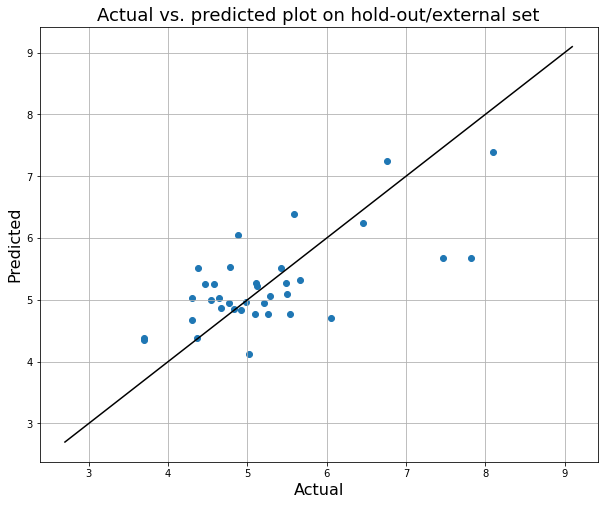

In [26]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))

# Morgan 1024 regression

## Training

In [16]:
TRAINING_CONFIGURATION_FILE = "Morgan_1024_training_gyrase_regression.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 08:16:05,942 - logger - INFO - CreateFPS fit...
2022-07-31 08:16:05,943 - logger - INFO - CreateFPS transform...


In [45]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

100%|██████████| 200/200 [12:00<00:00,  3.60s/it, best loss: 0.429320593426761] 


In [51]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 07:57:07,182 - logger - INFO - CreateFPS fit...
2022-07-31 07:57:07,185 - logger - INFO - CreateFPS fit...
2022-07-31 07:57:07,186 - logger - INFO - CreateFPS transform...
2022-07-31 07:57:07,276 - logger - INFO - R2 score on hold-out/external: -0.059983026657358884
2022-07-31 07:57:07,278 - logger - INFO - MSE score on hold-out/external: 1.061602145050705
2022-07-31 07:57:07,279 - logger - INFO - MAE score on hold-out/external: 0.6112107530145591


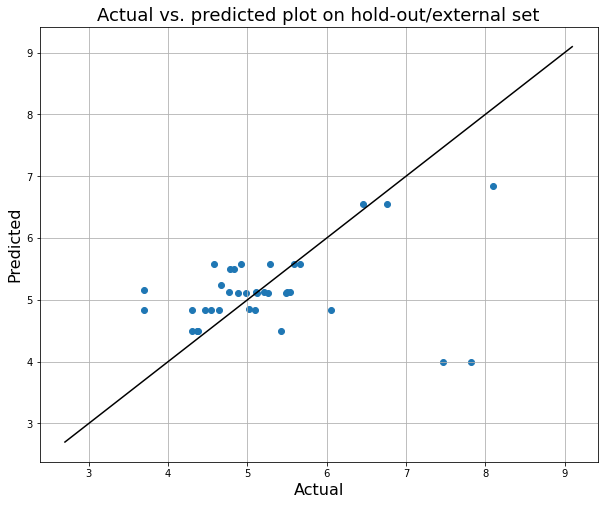

In [53]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))